# HW2 Colab Starter — CIFAR-10 Classification (5 epochs, tiny subset)
*Compute Diary:* Run the next cell at the start and end of each session. Keep total GPU time ≤ **90 minutes**.

In [9]:
from datetime import datetime
import os, json
stamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
os.makedirs("diary", exist_ok=True)
with open("diary/compute_diary.txt", "a") as f:
    f.write(json.dumps({"event": "timestamp", "when": stamp}) + "\n")
print("⏱️ Compute diary timestamp:", stamp)

⏱️ Compute diary timestamp: 2025-11-22 04:37:51


## 0) Environment & GPU check

In [2]:
import torch, platform
print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.12.3
Torch: 2.8.0+cu128
CUDA available: True
GPU: Tesla V100-PCIE-32GB


## 1) Reproducibility (fixed seeds)

In [3]:
import random, numpy as np, torch
def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0); print("✅ Seeds set to 0")

✅ Seeds set to 0


## 2) Data (CIFAR-10, fixed tiny subset)
- Use at most **20%** of the training set (change `SUBSET_FRACTION` if needed).
- Batch size ≤ 64.

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

SUBSET_FRACTION = 0.2   # set to 0.1 for even faster runs
BATCH_SIZE = 64

tfm_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
tfm_test  = transforms.ToTensor()

root = "./data"
train_full = datasets.CIFAR10(root, train=True, download=True, transform=tfm_train)
test_set   = datasets.CIFAR10(root, train=False, download=True, transform=tfm_test)

rng = np.random.default_rng(0)
subset_size = int(len(train_full) * SUBSET_FRACTION)
subset_idx = rng.choice(len(train_full), size=subset_size, replace=False)
train_set = Subset(train_full, subset_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train subset:", len(train_set), " Test:", len(test_set))

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s] 


Train subset: 10000  Test: 10000


## 3) Model (ResNet18) + 5-epoch training cap

In [5]:
import torch, torch.nn as nn
from torchvision.models import resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def make_model():
    m = resnet18(num_classes=10)
    return m.to(device)
EPOCHS = 5
LR = 1e-3

def train_one_config(optimizer_name="adam", use_cosine=False):
    model = make_model()
    if optimizer_name == "sgd":
        opt = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=LR)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS) if use_cosine else None
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "test_acc": []}
    for epoch in range(1, EPOCHS+1):
        model.train(); running=0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(); out = model(x); loss = criterion(out,y); loss.backward(); opt.step()
            running += loss.item()*x.size(0)
        train_loss = running/len(train_loader.dataset)
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(device), y.to(device)
                pred = model(x).argmax(1); correct += (pred==y).sum().item(); total += y.size(0)
        acc = correct/total
        if sched: sched.step()
        history["train_loss"].append(train_loss); history["test_acc"].append(acc)
        print(f"Epoch {epoch:02d} | loss={train_loss:.4f} | acc={acc:.3f}")
    return history
print("✅ Training utilities ready.")

✅ Training utilities ready.


## 4) Run two short ablations (pick two knobs)

In [6]:
results = {}
print("Run A: Adam + cosine"); results["adam_cosine"] = train_one_config("adam", True)
print("\nRun B: SGD + const");  results["sgd_const"]  = train_one_config("sgd", False)

Run A: Adam + cosine
Epoch 01 | loss=1.7217 | acc=0.387
Epoch 02 | loss=1.4154 | acc=0.472
Epoch 03 | loss=1.1961 | acc=0.473
Epoch 04 | loss=1.0057 | acc=0.542
Epoch 05 | loss=0.7805 | acc=0.630

Run B: SGD + const
Epoch 01 | loss=1.9532 | acc=0.369
Epoch 02 | loss=1.5930 | acc=0.411
Epoch 03 | loss=1.4403 | acc=0.457
Epoch 04 | loss=1.3052 | acc=0.438
Epoch 05 | loss=1.1974 | acc=0.497


## 5) Plot & tiny results table

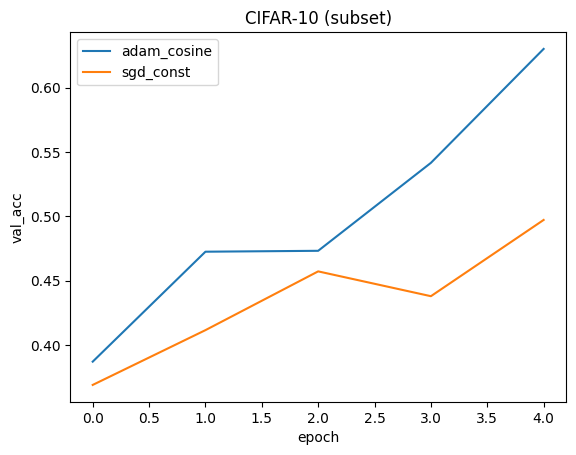

             final_train_loss  final_val_acc
adam_cosine          0.780451         0.6302
sgd_const            1.197357         0.4972


In [8]:
import matplotlib.pyplot as plt, pandas as pd
plt.figure()
for k,v in results.items():
    plt.plot(v["test_acc"], label=k)
plt.xlabel("epoch"); plt.ylabel("val_acc"); plt.title("CIFAR-10 (subset)"); plt.legend(); plt.show()
table = pd.DataFrame({k: [v["train_loss"][-1], v["test_acc"][-1]] for k,v in results.items()},
                     index=["final_train_loss","final_val_acc"]).T
print(table)

## 6) Reflection (3–5 sentences)
- Which knobs did you choose and why?
- What changed in curves/table?
- What would you try next with 10× more compute?

## 7) **Project sketch** (≈150 words) — counts toward HW2 *Process* (5 pts)
- **Question:** What are you trying to investigate?
- **Data:** Which dataset(s) or data source?
- **Metric(s):** What will you measure?
- **One ablation:** What single change will you compare vs baseline?
- **Constraints:** Acknowledge the course caps (≤5 epochs, ≤90 min GPU total, fixed subset allowed).
- **Teammates (if any):** List names/NetIDs.

> This is a draft. You can change it in the Dec 1 proposal.